In [82]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [83]:
def generate_noisy_quadrants(num_instances, noise_ratio=0.1):
  X = np.random.rand(num_instances, 2) * 2 - 1  # Features between -1 and 1
  y = np.zeros((num_instances,))

  # Classify based on quadrants (Ensuring class separation)
  y[(X[:, 0] > 0) & (X[:, 1] > 0)] = 1  # Quadrant 1 (Class 1)
  y[(X[:, 0] < 0) & (X[:, 1] < 0)] = 1  # Quadrant 3 (Class 1)
  y[(X[:, 0] < 0) & (X[:, 1] > 0)] = 2  # Quadrant 2 (Class 2)
  y[(X[:, 0] > 0) & (X[:, 1] < 0)] = 2  # Quadrant 4 (Class 2)

  # Add noise by flipping labels with a certain probability
  noise_mask = np.random.rand(num_instances) < noise_ratio
  y[noise_mask] = np.random.randint(1, 3, size=np.count_nonzero(noise_mask))  # Randomize between 1 and 2


  # Split data into training and test (assuming 50-50 split)
  train_size = int(num_instances / 2)
  train_X, train_y = X[:train_size], y[:train_size]
  test_X, test_y = X[train_size:], y[train_size:]

  return train_X, train_y, test_X, test_y

# Generate data with 400 instances (200 training, 200 test)
train_X, train_y, test_X, test_y = generate_noisy_quadrants(400, noise_ratio=0.1)


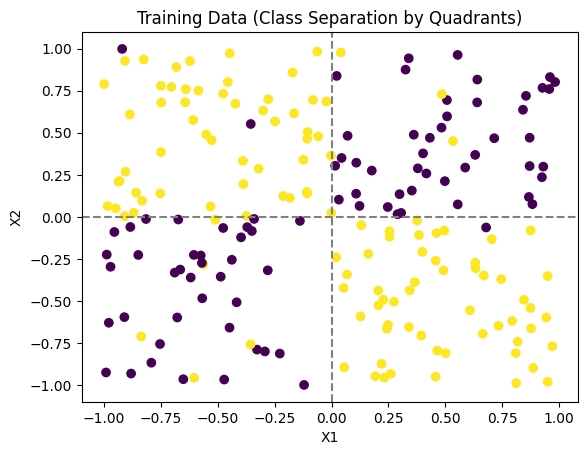

In [84]:
def plot_data(X, y, title="Quadrant Classification with Noise"):
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
  plt.title(title)
  plt.xlabel("X1")
  plt.ylabel("X2")
  plt.axhline(0, color="gray", linestyle="--")
  plt.axvline(0, color="gray", linestyle="--")
  plt.show()

# Plot training data
plot_data(train_X, train_y, title="Training Data (Class Separation by Quadrants)")

<span style="font-size:larger;">Multi Layer Perceptron</span>

In [85]:
regularization = None
lr = 0.001
input_features = 2
hidden_layer_neurons1 = 10
hidden_layer_neurons2 = 8
lambdas = [0.0001, 0.001, 0.01, 0.1]
epochs = 1000

In [86]:

# Define the MLP model
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y - 1, dtype=torch.long)  # Map 1 to 0 and 2 to 1

test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y - 1, dtype=torch.long)  # Map 1 to 0 and 2 to 1
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_layer_neurons1)  # Input layer to first hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_neurons1, hidden_layer_neurons2)  # First hidden layer to second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_neurons2, 2)  # Second hidden layer to output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [87]:
train_data, val_data, train_labels, val_labels = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Convert the training, validation, and test sets to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels - 1, dtype=torch.long)
val_data_tensor = torch.tensor(val_data, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels - 1, dtype=torch.long)
test_data_tensor = torch.tensor(test_X, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_y - 1, dtype=torch.long)

if( regularization !=None):

    # Define the regularization parameter values to try
    

    best_accuracy = 0.0
    best_lambda = None

    # Train the model with different values of lambda and select the best one based on validation accuracy
    for lambda_value in lambdas:
        # Initialize the model
        model = MLP()

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model with regularization
        for epoch in range(epochs):
            outputs = model(train_data_tensor)
            loss = criterion(outputs, train_labels_tensor)
            if regularization == 1:  # L1 regularization
                l1_reg = torch.tensor(0.)
                for param in model.parameters():
                    l1_reg += torch.norm(param, 1)
                loss += lambda_value * l1_reg
            elif regularization == 2:  # L2 regularization
                l2_reg = torch.tensor(0.)
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                loss += lambda_value * l2_reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        with torch.no_grad():
            val_outputs = model(val_data_tensor)
            _, predicted = torch.max(val_outputs, 1)
            accuracy = accuracy_score(val_labels_tensor, predicted)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_lambda = lambda_value

Epoch 0: Loss = 0.7105704545974731


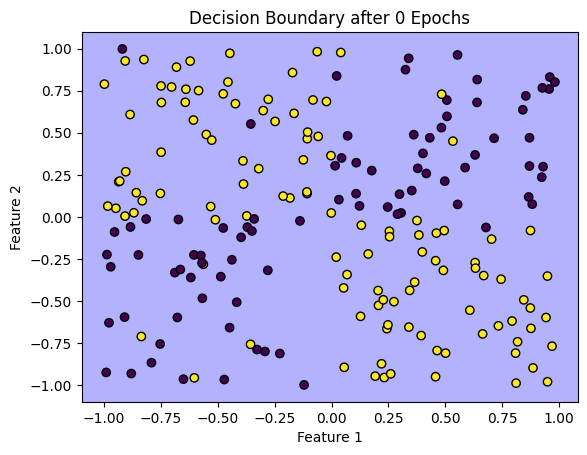

Epoch 100: Loss = 0.6188273429870605


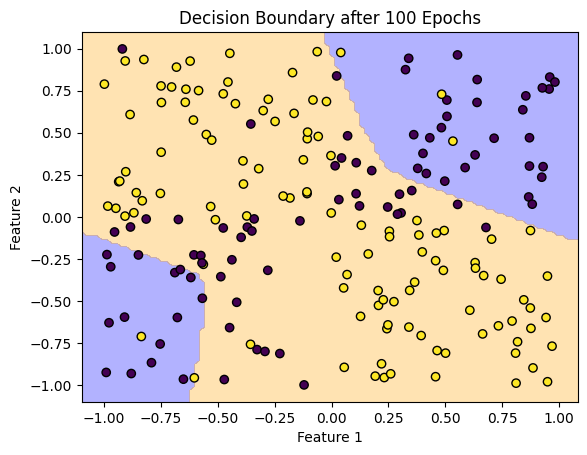

Epoch 200: Loss = 0.448649138212204


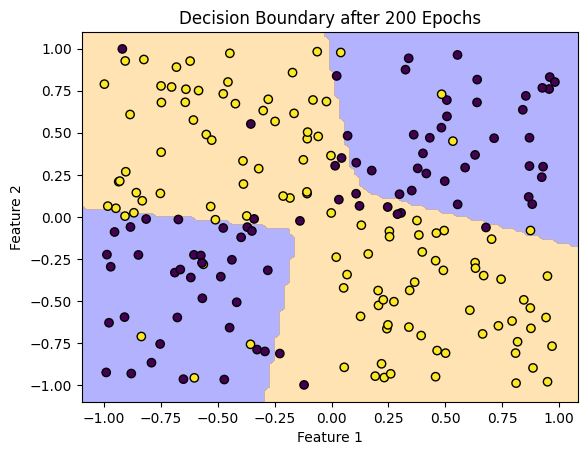

Epoch 300: Loss = 0.3476969003677368


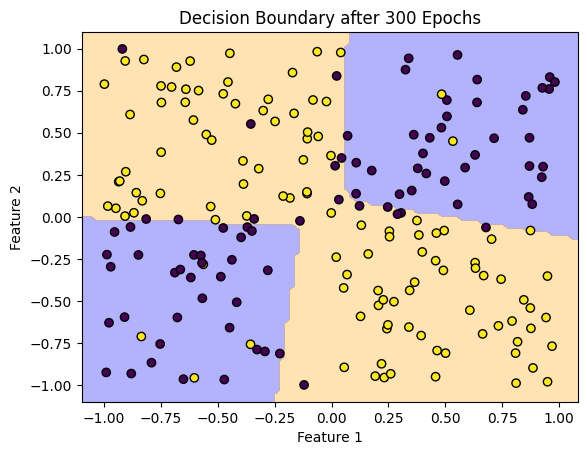

Epoch 400: Loss = 0.31559130549430847


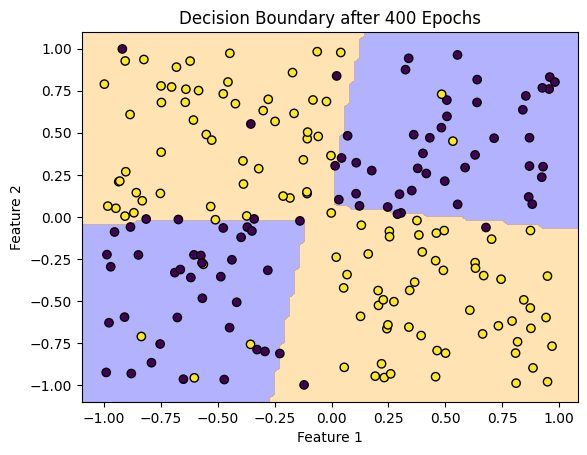

Epoch 500: Loss = 0.3006291687488556


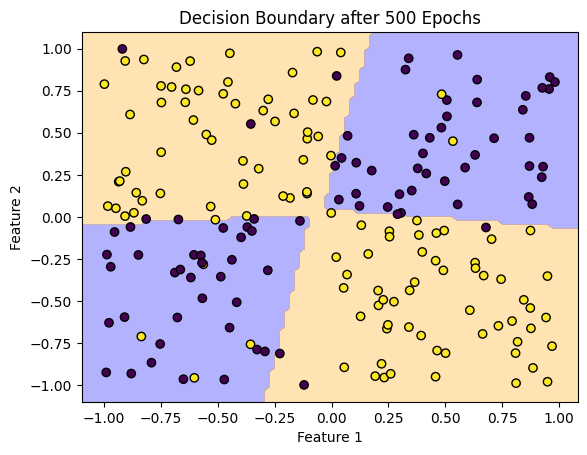

Epoch 600: Loss = 0.2859325110912323


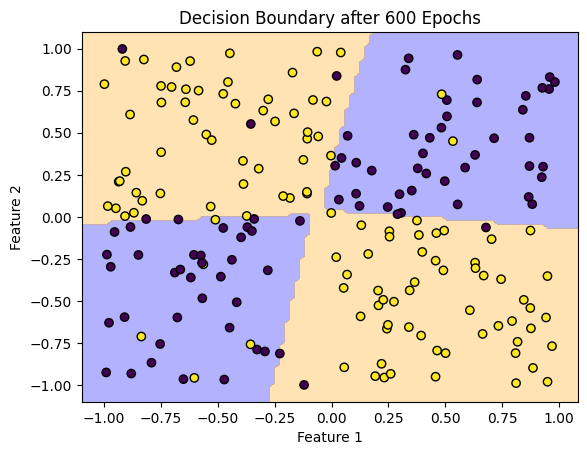

Epoch 700: Loss = 0.27166110277175903


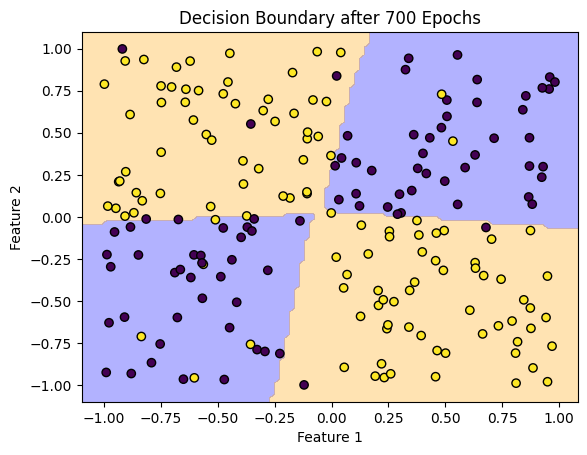

Epoch 800: Loss = 0.2585791349411011


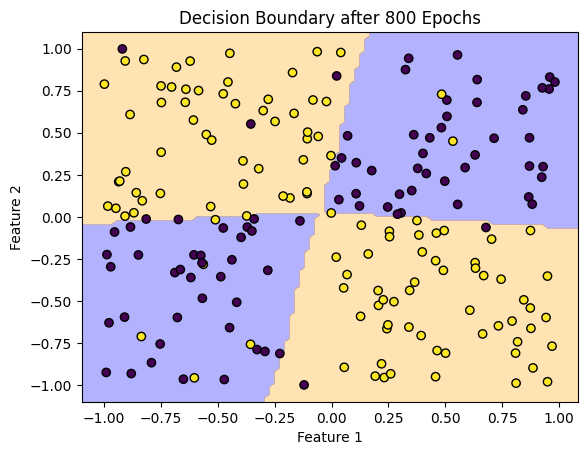

Epoch 900: Loss = 0.24652501940727234


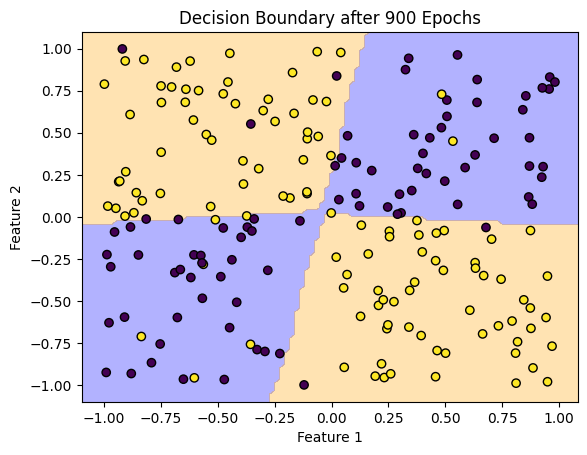

In [88]:
# Initialize the model
model = MLP()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define a meshgrid for the input space
x_min, x_max = train_X[:, 0].min() - 0.1, train_X[:, 0].max() + 0.1
y_min, y_max = train_X[:, 1].min() - 0.1, train_X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)

    # Regularization
    if regularization == 1:  # L1 regularization
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        loss += best_lambda * l1_reg
    elif regularization == 2:  # L2 regularization
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param, 2)
        loss += best_lambda * l2_reg

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress and plot decision boundary every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")
        
        with torch.no_grad():
            Z = model(grid_tensor).argmax(dim=1).reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=['blue', 'orange'])
            plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap='viridis', edgecolors='k')
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title('Decision Boundary after {} Epochs'.format(epoch))
            plt.show()


In [89]:
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(test_y_tensor, predicted)
    print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.905


<span style="font-size:larger;">Logistic Regression</span>

In [90]:
lr = 0.01
input_features = 5
epochs = 1000

In [91]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_features, 2)  # Input size is 5, output size is 2 for binary classification

    def forward(self, x):
        x = self.fc(x)
        return x

# Add additional features to the dataset
trx = np.c_[train_X, train_X[:, 0] * train_X[:, 1], train_X[:, 0]**2, train_X[:, 1]**2]
tsx = np.c_[test_X, test_X[:, 0] * test_X[:, 1], test_X[:, 0]**2, test_X[:, 1]**2]

# Convert the training and test sets to PyTorch tensors
X_train_tensor = torch.tensor(trx, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y - 1, dtype=torch.long)  # Map 1 to 0 and 2 to 1
X_test_tensor = torch.tensor(tsx, dtype=torch.float32)
y_test_tensor = torch.tensor(test_y - 1, dtype=torch.long)

Epoch 0: Loss = 0.7378660440444946


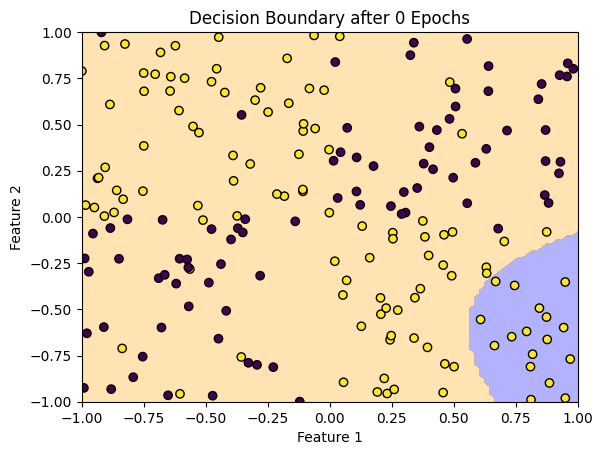

Epoch 100: Loss = 0.5551525354385376


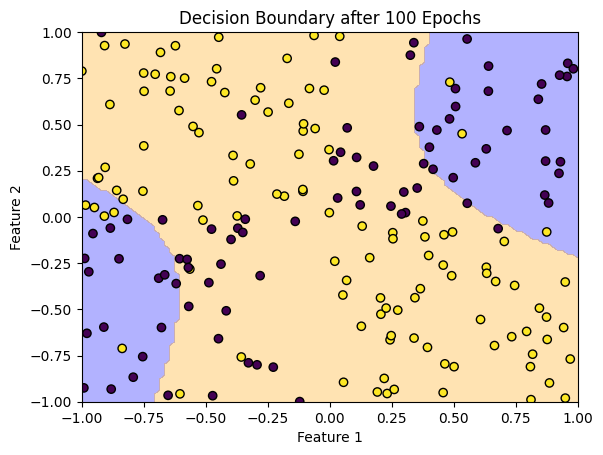

Epoch 200: Loss = 0.48055827617645264


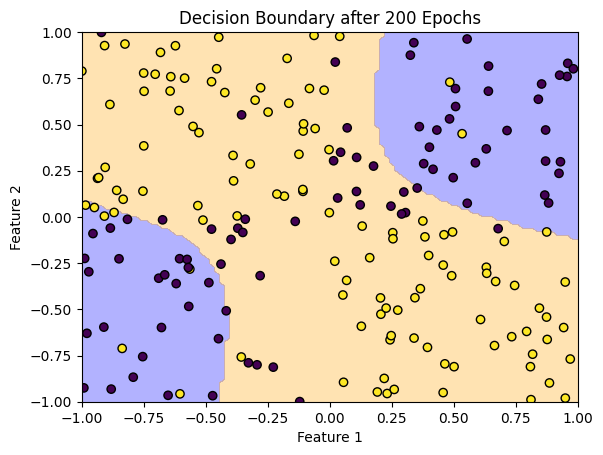

Epoch 300: Loss = 0.44406840205192566


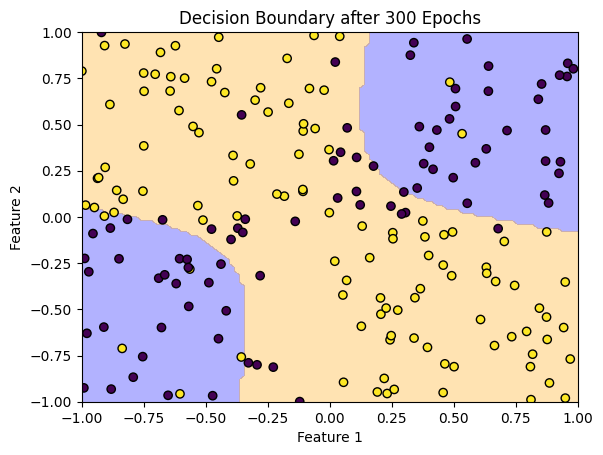

Epoch 400: Loss = 0.4236803948879242


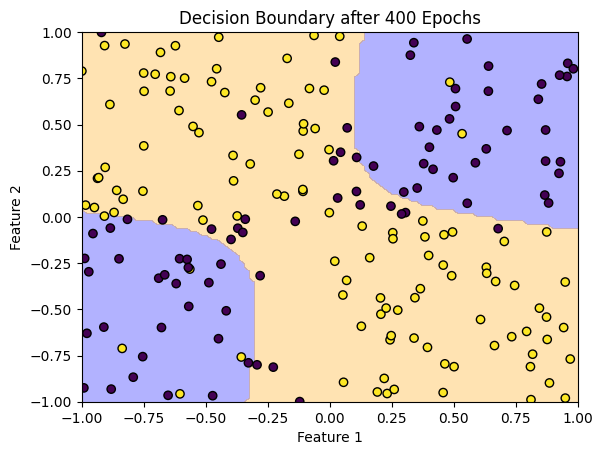

Epoch 500: Loss = 0.4112437069416046


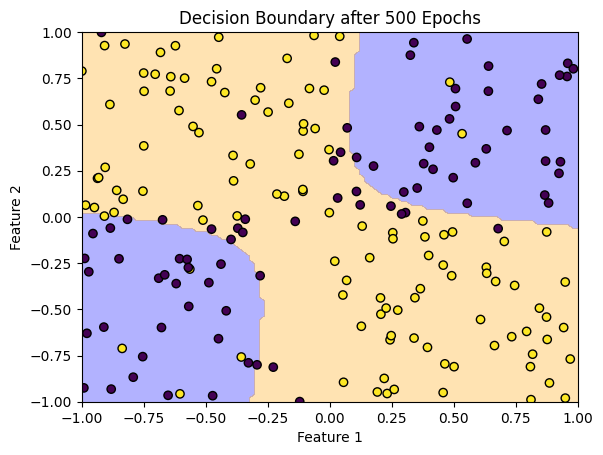

Epoch 600: Loss = 0.40322840213775635


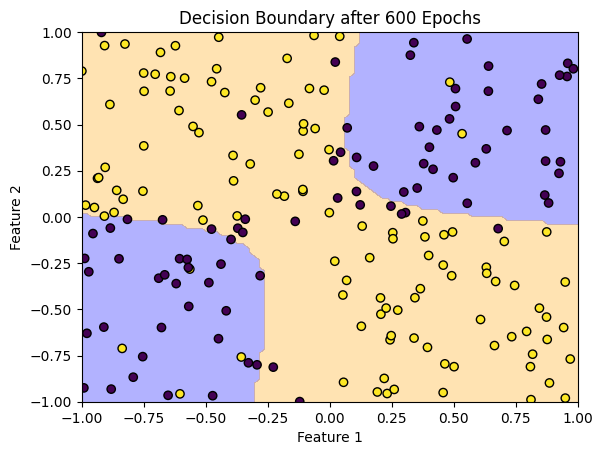

Epoch 700: Loss = 0.3978808522224426


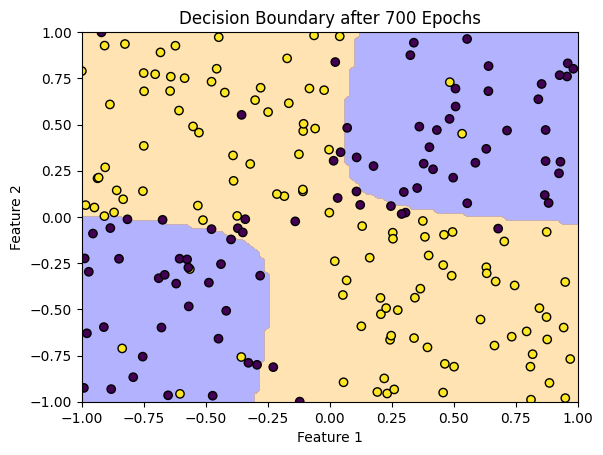

Epoch 800: Loss = 0.39423611760139465


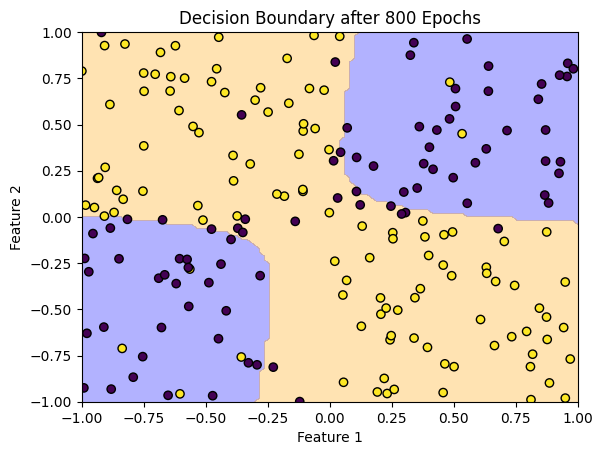

Epoch 900: Loss = 0.39172080159187317


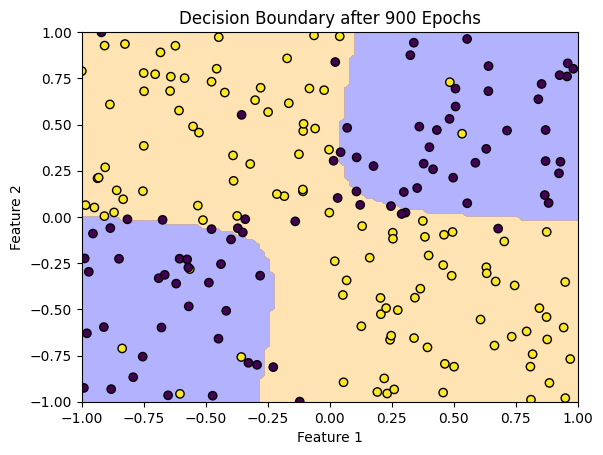

In [92]:
model = LogisticRegression()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:  # Plot the decision boundary after every 100 epochs
        print(f"Epoch {epoch}: Loss = {loss.item()}")
        with torch.no_grad():
            xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
            grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel(), xx.ravel() * yy.ravel(), xx.ravel()**2, yy.ravel()**2], dtype=torch.float32)
            Z = model(grid_tensor).argmax(dim=1).reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], colors=['blue', 'orange'])
            plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap='viridis', edgecolors='k')
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.title('Decision Boundary after %d Epochs' % (100 * epoch // 100))
            plt.show()

In [93]:
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test_tensor, predicted)
    print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.875
